In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn
import scipy.interpolate 
import cv2
import time
import itertools
import ot
import glob
import os
from utils.utils import *
import ot

In [4]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
pairs = list(itertools.combinations(image_numbers, 2))

categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = glob.glob(categories_pattern)
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

In [13]:
def calculate_2d_frequencies(n_rows, n_cols):
    # Compute frequency values for each axis
    fy = np.fft.fftfreq(n_rows).reshape(-1, 1)  # Frequencies in y-direction
    fx = np.fft.fftfreq(n_cols)  # Frequencies in x-direction
    
    # Create a meshgrid of frequencies: combines fx and fy to form a grid of vectors
    fx, fy = np.meshgrid(fx, fy)
    
    # Calculate the magnitude of the frequency vectors
    # This represents |k|, the distance from the origin to each point in frequency space
    freq_magnitude = np.sqrt(fx**2 + fy**2)
    
    return freq_magnitude

def calculate_costs(size, distance_metric='L1'):
    """
    This function of an array or image and calculates the cost from it to itself.

    Parameters:
    - `size` (int or tuple): representing the object on which we would like to calculate costs.

    Returns:
    - `costs` (numpy.ndarray): A 2D array representing the matrix of costs of transporting pixels
                                from the first image to the second image.
    """

    # Helper function for L1 and L2 distance
    if distance_metric == 'L1':
        dist = lambda a, b: abs(a - b)
    elif distance_metric == 'L2':
        dist = lambda a, b: (a - b) ** 2
    else:
        raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')

    # 1D case:
    if isinstance(size, int):
        X = np.linspace(0, 1, size)
        costs = np.zeros([size, size], np.float64)

        for it1 in range(size):
            for it2 in range(size):
                costs[it1, it2] = dist(X[it1], X[it2])

        return costs

    # 2D case:
    elif len(size) == 2:
        m, n = size
        size_1d = m * n

        coords = np.array([[i, j] for i in range(m) for j in range(n)])
        delta = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]

        if distance_metric == 'L1':
            distances = np.sum(np.abs(delta), axis=2)
        elif distance_metric == 'L2':
            distances = np.sqrt(np.sum(delta ** 2, axis=2))
        else:
            raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')

        costs = distances.reshape((size_1d, size_1d))

        return costs

In [14]:
p = 2
s = 2
T = 16
d = 2

In [15]:
pfm_values_normal = []
pfm_values_shifted = []
w_values = []

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        # Calculate the fft
        im1_ft = np.fft.fft2(im1)
        im1_ft_shift = np.fft.fftshift(im1_ft)
        im1_ft_shift_normalized = np.log(np.abs(im1_ft_shift) + 1)

        im2_ft = np.fft.fft2(im2)
        im2_ft_shift = np.fft.fftshift(im2_ft)
        im2_ft_shift_normalized = np.log(np.abs(im2_ft_shift) + 1)

        # Calculate the PFM
        diff = np.abs(im1_ft - im2_ft) ** p
        freqs = calculate_2d_frequencies(*im1_ft.shape)
        freqs[freqs == 0] = 1e-5
        weighted_diff = diff / (freqs ** (s*p))
        pfm = ((np.sum(weighted_diff)) ** (1/p)) / (T**d)
        pfm_values_normal.append(pfm)
        
        #Calculate shifted values:
        diff = np.abs(im1_ft_shift - im2_ft_shift) ** p
        weighted_diff = diff / (freqs ** (s*p))
        pfm = ((np.sum(weighted_diff)) ** (1/p)) / (T**d)
        pfm_values_shifted.append(pfm)

        #Calculate the EMD
        cost_matrix = calculate_costs(im1.shape, distance_metric = 'L2')
        w_dist = ot.emd2(im1.flatten(), im2.flatten(), cost_matrix)
        w_values.append(w_dist)
    
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

4.633738040924072 Time elapsed for Category CauchyDensity
7.08188533782959 Time elapsed for Category ClassicImages
6.177074432373047 Time elapsed for Category GRFmoderate
6.672017574310303 Time elapsed for Category GRFrough
6.766861200332642 Time elapsed for Category GRFsmooth
5.01680064201355 Time elapsed for Category LogGRF
5.585718393325806 Time elapsed for Category LogitGRF
3.3296959400177 Time elapsed for Category MicroscopyImages
2.1657345294952393 Time elapsed for Category Shapes
7.015761137008667 Time elapsed for Category WhiteNoise


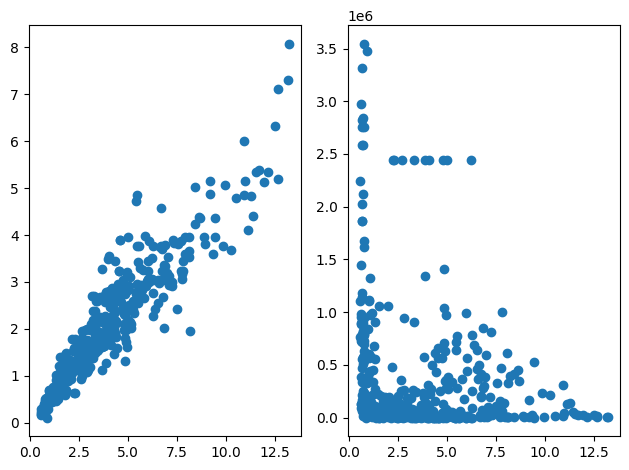

In [16]:
plt.subplot(1,2,1)
plt.scatter(w_values, pfm_values_normal)

plt.subplot(1,2,2)
plt.scatter(w_values, pfm_values_shifted)

plt.tight_layout()
plt.show()